# Random Forest Regression - World Food Program Disaster Relief -

*@XavierTorres*

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import math

In [2]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from warnings import simplefilter

In [3]:
df = pd.read_csv(r'Data_input/OUTPUT_WBI_exposer_cyclones_v14.csv', sep=";")

## Stratified Sampling

In [4]:
df1 = df.copy()

### Here you can add any further features that you want to include

df1.reset_index(drop=True,inplace=True)

In [5]:
df1.dropna(subset=['POP_MAX_34_ADJ'], inplace=True)

- Finding the feature with the heighest correlation, to stratify the train and test sets


In [6]:
corr_matrix = df1.corr()
corr_matrix['TOTAL_AFFECTED'].sort_values(ascending = False)

TOTAL_AFFECTED                                        1.000000
POP_MAX_50_ADJ                                        0.386008
POP_MAX_34_ADJ                                        0.310021
POP_MAX_64_ADJ                                        0.209224
Net flows from UN agencies US$                        0.201756
34KN_POP                                              0.193702
96KN_POP                                              0.174816
64KN_POP                                              0.152556
RURAL_POP(%)                                          0.122999
MAX_WIND                                              0.105685
TOTAL_HOURS_IN_LAND                                   0.103369
MAX_USA_SSHS                                          0.082895
Cereal yield (kg per hectare)                         0.077225
YEAR                                                  0.072792
POP_DEN_SQ_KM                                         0.067576
TOTAL_DEATHS                                          0

In [7]:
strat_col = 'POP_MAX_34_ADJ'

In [8]:
df[strat_col].describe()

count    9.110000e+02
mean     2.770093e+07
std      4.367805e+07
min      0.000000e+00
25%      3.072560e+06
50%      1.099835e+07
75%      3.286035e+07
max      3.764972e+08
Name: POP_MAX_34_ADJ, dtype: float64

- Create the bins and make sure that the highest values of the column are included

In [9]:
max(df1[strat_col])

376497216.0

In [10]:
bins = [0, 10000,100000, 500000,1000000, 5000000, 10000000, 25000000, 50000000 ,100000000, 500000000]

In [11]:
df1[strat_col +'_cat']= pd.cut(df1[strat_col], bins, include_lowest=True)

In [12]:
df1[[strat_col +'_cat', strat_col]]

,POP_MAX_34_ADJ_cat,POP_MAX_34_ADJ
0,"(10000000.0, 25000000.0]",1.198300e+07
1,"(25000000.0, 50000000.0]",3.160822e+07
2,"(1000000.0, 5000000.0]",1.689243e+06
3,"(1000000.0, 5000000.0]",4.760039e+06
4,"(5000000.0, 10000000.0]",5.130796e+06
...,...,...
984,"(50000000.0, 100000000.0]",5.600261e+07
986,"(1000000.0, 5000000.0]",2.396895e+06
987,"(100000.0, 500000.0]",2.341183e+05
989,"(1000000.0, 5000000.0]",3.758703e+06


In [13]:
df1['POP_MAX_34_ADJ_cat'].isna().sum()

0

In [14]:
df1['POP_MAX_34_ADJ_cat'].value_counts().sort_index()

(-0.001, 10000.0]               9
(10000.0, 100000.0]            36
(100000.0, 500000.0]           36
(500000.0, 1000000.0]          35
(1000000.0, 5000000.0]        192
(5000000.0, 10000000.0]       117
(10000000.0, 25000000.0]      206
(25000000.0, 50000000.0]      127
(50000000.0, 100000000.0]      93
(100000000.0, 500000000.0]     60
Name: POP_MAX_34_ADJ_cat, dtype: int64

- Check that there are no NaN in the column, because this will break StratifiedShuffleSplit

In [15]:
df1[strat_col +'_cat'].isna().sum()

0

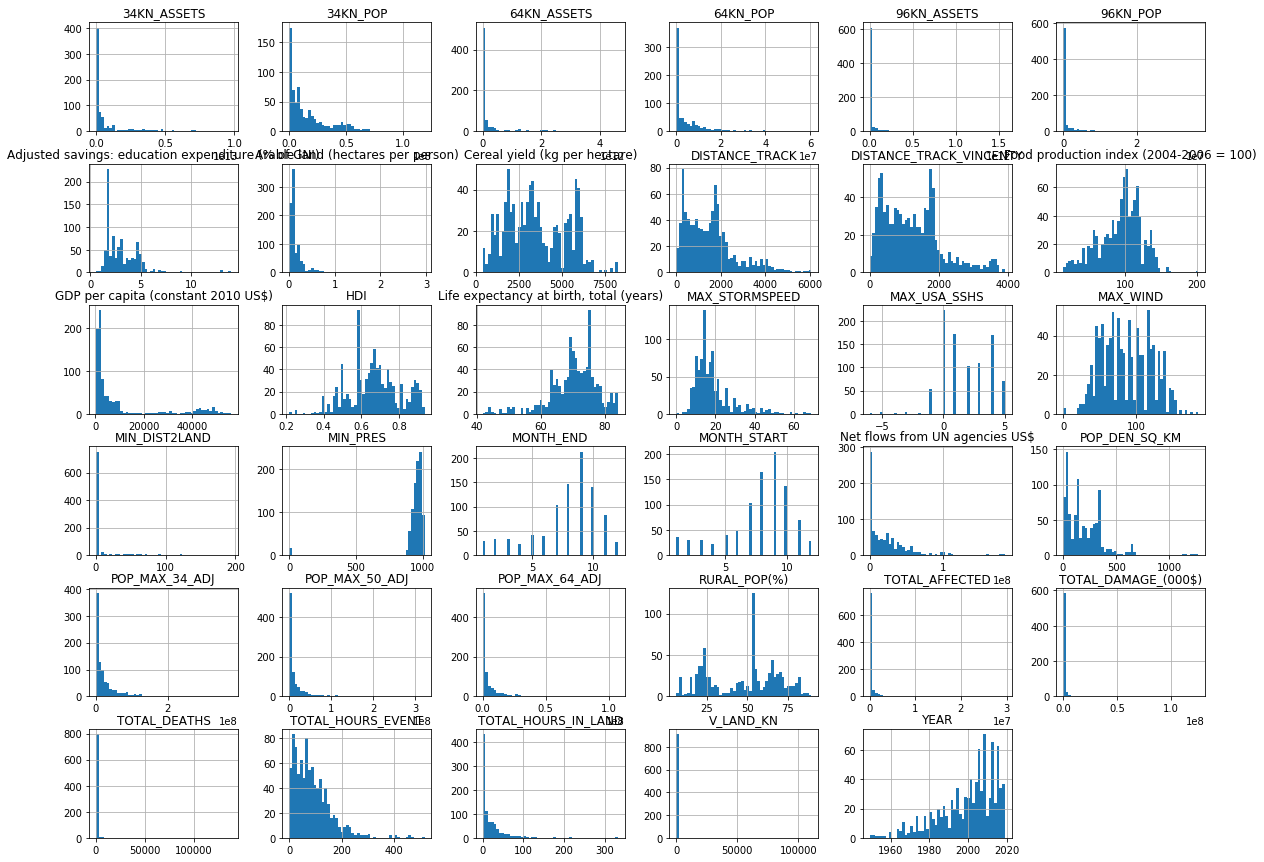

In [16]:
df1.hist(bins=50, figsize=(20,15))
plt.show()

## Data pre-processing

In [17]:
df1.shape

(911, 52)

In [18]:
df1.columns

Index(['SID', 'NAME', 'ISO', 'YEAR', 'COORDS', 'COORDS_MAX_WINDS',
       'COORDS_MIN_DIST2LAND', 'BASIN', 'SUB BASIN', 'MONTH_START',
       'MONTH_END', 'DATE_START', 'DATE_END', 'DATE_LAND_START',
       'DATE_LAND_END', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'NATURE',
       'GENERAL_CATEGORY', 'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND',
       'MAX_STORMSPEED', 'MAX_USA_SSHS', 'MAX_USA_SSHS_INLAND', 'V_LAND_KN',
       'DISTANCE_TRACK', 'DISTANCE_TRACK_VINCENTY', '34KN_POP', '64KN_POP',
       '96KN_POP', '64KN_ASSETS', '34KN_ASSETS', '96KN_ASSETS',
       'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS', 'POP_DEN_SQ_KM', 'RURAL_POP(%)',
       'HDI', 'Arable land (hectares per person)',
       'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final'

In [19]:
# Arranging columns

df1 = df1[[
    # cols from cyclones
    'SID', 'NAME', 'ISO', 'YEAR', 'COORDS', 'COORDS_MAX_WINDS',
       'COORDS_MIN_DIST2LAND', 'BASIN', 'SUB BASIN', 'NATURE', 
    'MONTH_START',
    #'MONTH_END', 'DATE_START', 'DATE_END', 'DATE_LAND_START', 'DATE_LAND_END', 
    'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 
       'GENERAL_CATEGORY', 'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND',
       'MAX_STORMSPEED', 'MAX_USA_SSHS', 'MAX_USA_SSHS_INLAND', 'V_LAND_KN',
       'DISTANCE_TRACK', 'DISTANCE_TRACK_VINCENTY', '34KN_POP', '64KN_POP',
       '96KN_POP', '64KN_ASSETS', '34KN_ASSETS', '96KN_ASSETS',
       'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS', 
    

    # cols from World Bank Indicators:           
    'POP_DEN_SQ_KM', 'RURAL_POP(%)',
       'HDI', 'Arable land (hectares per person)',
       'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final',
    
    
    # cols from climada:   
        'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ','POP_MAX_64_ADJ', 'POP_MAX_34_ADJ_cat',
    
    # Target 
    'TOTAL_AFFECTED']]

In [20]:
df1.head(3)

,SID,NAME,ISO,YEAR,COORDS,COORDS_MAX_WINDS,COORDS_MIN_DIST2LAND,BASIN,SUB BASIN,NATURE,...,GDP per capita (constant 2010 US$),Net flows from UN agencies US$,"Life expectancy at birth, total (years)",Adjusted savings: education expenditure (% of GNI),Income_level_Final,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,POP_MAX_34_ADJ_cat,TOTAL_AFFECTED
0,1949163N07145,DELLA,JPN,1949,"[(21.5, 125.424), (22.2, 125.8), (22.9089, 126...","[(27.6584, 128.82), (28.9141, 129.572999999999...","[(31.9866, 130.683), (33.5183, 130.97299999999...",WP,WP,TS,...,8607.657082,0.0,67.666098,2.867878,Low,1.198300e+07,5.803981e+06,3.320907e+06,"(10000000.0, 25000000.0]",194046
1,1950241N23140,JANE,JPN,1950,"[(23.8845, 139.74), (23.9335, 139.639), (23.98...","[(28.7509, 133.748), (29.1201, 133.762), (29.6...","[(34.9374, 135.476), (36.1016, 136.095), (37.2...",WP,WP,ET,...,8607.657082,0.0,67.666098,2.867878,Low,3.160822e+07,1.559196e+07,1.018936e+07,"(25000000.0, 50000000.0]",642117
2,1951224N12316,CHARLIE,JAM,1951,"[(17.3398, -75.4138), (17.6, -76.2), (17.9, -7...","[(17.6, -76.2), (17.9, -76.9)]","[(17.9, -76.9), (18.1, -77.8)]",NAm,CS,TS,...,3796.219401,0.0,64.770000,2.578304,Low,1.689243e+06,1.687083e+06,1.195052e+06,"(1000000.0, 5000000.0]",20200


- **Checking nulls**

In [21]:
# Checking quantity of missing data. Reusing code from Fabi
def null_cols(data):

    """
    This function takes a dataframe df and shows the columns of df that have NaN values
    and the number of them

    """
    nulls = data.isna().sum()
    nulls = nulls[nulls > 0] / len(data) * 100
    nulls = pd.DataFrame(nulls.sort_values(ascending = False))
    nulls = nulls.reset_index().rename(columns = {"index": "Feature", 0: "% Null rows"})
    return nulls

In [22]:
null_cols(df1)

,Feature,% Null rows
0,TOTAL_DAMAGE_(000$),29.967069
1,96KN_ASSETS,21.844127
2,34KN_ASSETS,21.844127
3,64KN_ASSETS,21.844127
4,96KN_POP,21.734358
5,64KN_POP,21.734358
6,34KN_POP,21.734358
7,TOTAL_DEATHS,11.855104
8,GDP per capita (constant 2010 US$),0.878156
9,Adjusted savings: education expenditure (% of ...,0.439078


- **MAX_USA_SSHS** and **MAX_USA_SSHS_INLAND** columns with value -6 = Unknown:

In [23]:
df1["MAX_USA_SSHS"]= df1["MAX_USA_SSHS"].replace(-6, np.nan) 
df1["MAX_USA_SSHS_INLAND"]= df1["MAX_USA_SSHS_INLAND"].replace('-6', np.nan) 

- Trying to create a calculated column that better represents de relative dimension **of exposed assets**. We have several columns for assets exposed depending of windspeed for 34kn+, 64kn+ and 96kn+. Let's add these columns to create a new column:

In [24]:
df1['CALC_assets_emdat'] = df1['34KN_ASSETS'] + df1['64KN_ASSETS'] + df1['96KN_ASSETS']
df1 = df1.drop(['34KN_ASSETS', '64KN_ASSETS','96KN_ASSETS'], axis=1)

In [25]:
df1["MAX_USA_SSHS"].describe()

count    910.000000
mean       1.810989
std        1.885469
min       -5.000000
25%        0.000000
50%        1.000000
75%        4.000000
max        5.000000
Name: MAX_USA_SSHS, dtype: float64

- **Transform 'Income_Level'** categories to ordered integers and **BASIN, SUB BASIN,NATURE and GENERAL_CATEGORY** into Category Type

In [26]:
#Arnab code
unique_list = df['Income_level_Final'].unique()
incomelevel_to_int = dict(zip(unique_list, [1,2,4,3])) # so we assign['Low' =1, 'Low_Middle' =2, 'High'=4, 'High_Middle'=3]
df1['Income_level_Final'] = df1['Income_level_Final'].apply(lambda inc_level: incomelevel_to_int[inc_level])

In [27]:
df1['BASIN'] = df1['BASIN'].astype('category')
df1['SUB BASIN'] = df1['SUB BASIN'].astype('category')
df1['NATURE'] = df1['NATURE'].astype('category')
df1['GENERAL_CATEGORY'] = df1['GENERAL_CATEGORY'].astype('category')

- **Create New Column fro 'No Landing'**

In [28]:
df1['Landing'] = np.where(df1['MAX_USA_SSHS_INLAND'] == 'No landing', 0, 1)

In [29]:
#assign np.nan to columns with 'No landing'  value

df1["MAX_USA_SSHS_INLAND"]= df1["MAX_USA_SSHS_INLAND"].replace('No landing', np.nan) 

In [30]:
df1["MAX_USA_SSHS_INLAND"] = df1["MAX_USA_SSHS_INLAND"].astype('float')

- **Arranging columns**

In [31]:
df1.shape

(911, 46)

In [32]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 911 entries, 0 to 990
Data columns (total 46 columns):
SID                                                   911 non-null object
NAME                                                  911 non-null object
ISO                                                   911 non-null object
YEAR                                                  911 non-null int64
COORDS                                                911 non-null object
COORDS_MAX_WINDS                                      911 non-null object
COORDS_MIN_DIST2LAND                                  911 non-null object
BASIN                                                 911 non-null category
SUB BASIN                                             911 non-null category
NATURE                                                911 non-null category
MONTH_START                                           911 non-null int64
TOTAL_HOURS_EVENT                                     911 non-null float64
TO

In [33]:
df1.columns

Index(['SID', 'NAME', 'ISO', 'YEAR', 'COORDS', 'COORDS_MAX_WINDS',
       'COORDS_MIN_DIST2LAND', 'BASIN', 'SUB BASIN', 'NATURE', 'MONTH_START',
       'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'GENERAL_CATEGORY',
       'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND', 'MAX_STORMSPEED',
       'MAX_USA_SSHS', 'MAX_USA_SSHS_INLAND', 'V_LAND_KN', 'DISTANCE_TRACK',
       'DISTANCE_TRACK_VINCENTY', '34KN_POP', '64KN_POP', '96KN_POP',
       'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS', 'POP_DEN_SQ_KM', 'RURAL_POP(%)',
       'HDI', 'Arable land (hectares per person)',
       'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final', 'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ',
       'POP_MAX_64_ADJ', 'POP_MAX_34_ADJ_cat', 'TOTAL_AFFECTED',
       'CALC_assets_emdat', 'La

In [34]:
#taking out from model=    'SID', 'NAME', 'ISO', 'YEAR', 'COORDS', 'COORDS_MAX_WINDS','COORDS_MIN_DIST2LAND', 
# Arranging columns

df1 = df1[[
    # cols from cyclones
    'BASIN', 'SUB BASIN', 'NATURE', 'MONTH_START',
       'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'GENERAL_CATEGORY',
       'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND', 'MAX_STORMSPEED',
       'MAX_USA_SSHS', 'MAX_USA_SSHS_INLAND', 'V_LAND_KN', 'DISTANCE_TRACK',
       'DISTANCE_TRACK_VINCENTY', '34KN_POP', '64KN_POP', '96KN_POP',
       'TOTAL_DAMAGE_(000$)', 'CALC_assets_emdat', 'Landing', 
    'TOTAL_DEATHS',
    

    # cols from World Bank Indicators:           
    'POP_DEN_SQ_KM', 'RURAL_POP(%)',
       'HDI', 'Arable land (hectares per person)',
       'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final',
    
    
    # cols from climada:   
        'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ', 'POP_MAX_64_ADJ', 'POP_MAX_34_ADJ_cat',
    
    # Target 
    'TOTAL_AFFECTED']]

- **Check SKEWENESS and apply log**

In [35]:
#determine index for continous variables
num_feats = df1.dtypes[df1.dtypes != 'object'].index

#Calculate skew and sort
skew_feats = df1[num_feats].skew().sort_values(ascending = False)
skewness = pd.DataFrame({'Skew': skew_feats})

In [36]:
skewness

,Skew
V_LAND_KN,30.179351
TOTAL_DEATHS,27.443095
TOTAL_DAMAGE_(000$),11.367728
TOTAL_AFFECTED,7.001366
96KN_POP,6.635357
Arable land (hectares per person),5.517063
POP_MAX_50_ADJ,4.316617
TOTAL_HOURS_IN_LAND,3.855884
POP_MAX_64_ADJ,3.731450
MIN_DIST2LAND,3.416145


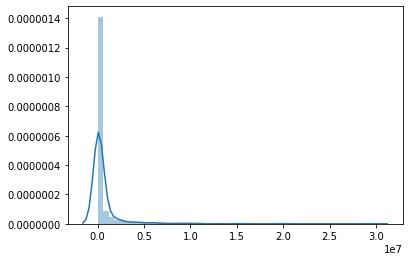

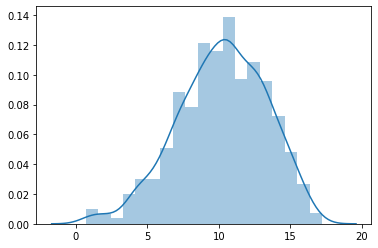

<Figure size 432x288 with 0 Axes>

In [37]:
# Checking distribution for one feature---reusing code from Juber
ax=sns.distplot(df1['TOTAL_AFFECTED'].values)

plt.show()
plt.clf()

log_affected=np.log(df1['TOTAL_AFFECTED'].values)
ax=sns.distplot(log_affected)

plt.show()
plt.clf()

In [38]:
# Creating list of features to transform, for skew values above 2.00

feats_to_log = skewness[skewness['Skew'] > 2.00].index

In [39]:
feats_to_log

Index(['V_LAND_KN', 'TOTAL_DEATHS', 'TOTAL_DAMAGE_(000$)', 'TOTAL_AFFECTED',
       '96KN_POP', 'Arable land (hectares per person)', 'POP_MAX_50_ADJ',
       'TOTAL_HOURS_IN_LAND', 'POP_MAX_64_ADJ', 'MIN_DIST2LAND',
       'POP_MAX_34_ADJ', '64KN_POP', 'CALC_assets_emdat',
       'Adjusted savings: education expenditure (% of GNI)',
       'Net flows from UN agencies US$', 'POP_DEN_SQ_KM'],
      dtype='object')

In [40]:
#apply log to some features

for item in feats_to_log:
    #df[item]=np.log((df[item] + 1 - df[item].min()).values)
    df1[item] = df1[item].apply(lambda x: np.log(x) if x>0 else 0)
    

In [41]:
df1[feats_to_log].describe()

,V_LAND_KN,TOTAL_DEATHS,TOTAL_DAMAGE_(000$),TOTAL_AFFECTED,96KN_POP,Arable land (hectares per person),POP_MAX_50_ADJ,TOTAL_HOURS_IN_LAND,POP_MAX_64_ADJ,MIN_DIST2LAND,POP_MAX_34_ADJ,64KN_POP,CALC_assets_emdat,Adjusted savings: education expenditure (% of GNI),Net flows from UN agencies US$,POP_DEN_SQ_KM
count,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000
mean,4.441211,2.673830,7.857921,10.205479,4.336637,-2.194853,14.620874,2.008393,12.848332,0.665759,15.859392,8.386231,19.939106,1.030220,12.998137,4.793924
std,0.450720,1.897876,5.596337,3.097558,6.224082,0.871081,3.429903,1.553450,4.664797,1.490443,2.243766,7.334328,10.823385,0.493615,6.981490,1.165317
min,3.401197,0.000000,0.000000,0.693147,0.000000,-4.726222,0.000000,-0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,-0.618261,0.000000,0.620576
25%,4.137563,1.098612,0.000000,8.202238,0.000000,-2.806086,13.871218,0.000000,12.530833,0.000000,14.938022,0.000000,20.627419,0.598433,14.207187,3.951227
50%,4.497585,2.639057,9.886697,10.318507,0.000000,-2.356453,15.289612,2.197225,14.264136,0.000000,16.213256,12.151896,24.825214,0.993252,16.531529,5.003946
75%,4.747104,3.921924,12.297397,12.493082,11.403918,-1.644715,16.643616,3.295837,15.565118,0.000000,17.307775,15.305258,26.970273,1.451725,17.315346,5.717028
max,11.614498,11.837658,18.643824,17.204028,17.419063,1.085620,19.590919,5.808142,18.491778,5.267858,19.746421,17.919354,30.327201,2.639771,19.029087,7.146772


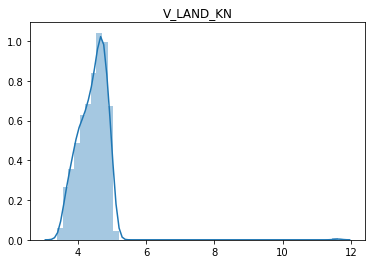

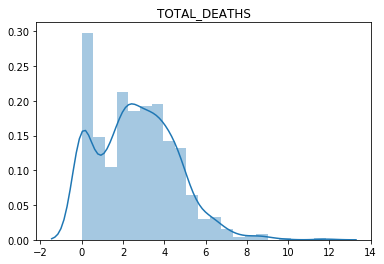

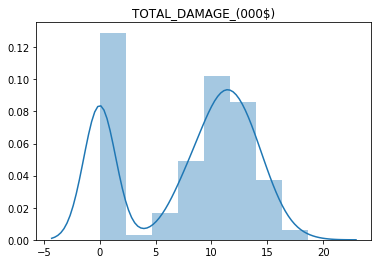

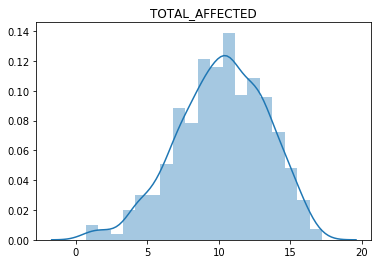

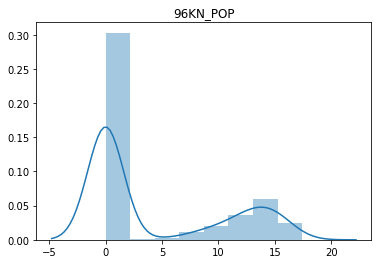

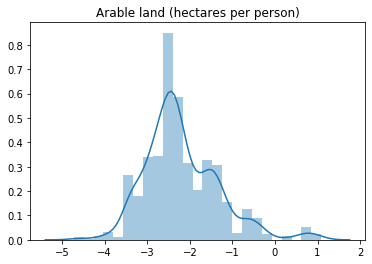

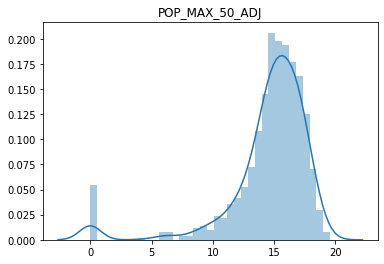

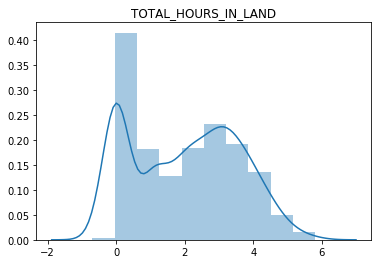

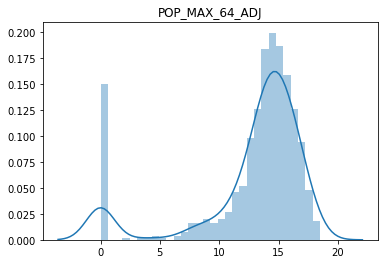

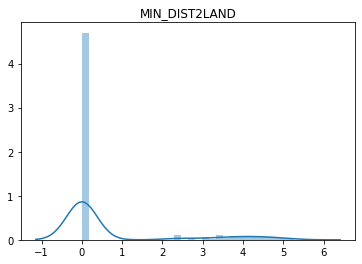

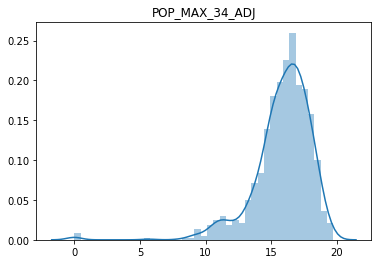

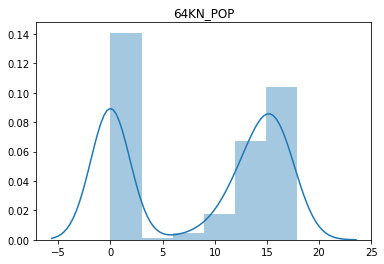

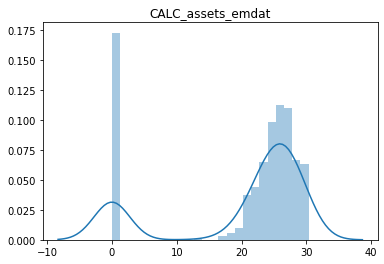

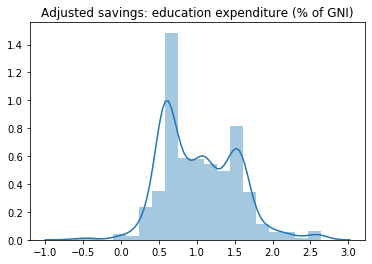

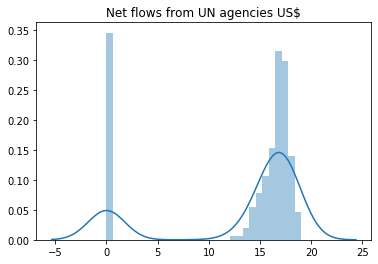

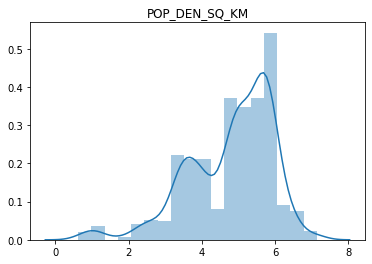

<Figure size 432x288 with 0 Axes>

In [42]:
for item in feats_to_log:
    ax=sns.distplot(df1[item].values)
    ax.set_title(item);
    plt.show()
    plt.clf()


In [43]:
df1.describe()

,MONTH_START,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,MAX_USA_SSHS_INLAND,V_LAND_KN,...,Food production index (2004-2006 = 100),GDP per capita (constant 2010 US$),Net flows from UN agencies US$,"Life expectancy at birth, total (years)",Adjusted savings: education expenditure (% of GNI),Income_level_Final,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,TOTAL_AFFECTED
count,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,909.000000,910.000000,751.000000,911.000000,...,911.000000,903.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000
mean,7.792536,87.795646,2.008393,87.140009,941.511526,0.665759,18.490649,1.810989,0.837550,4.441211,...,93.462000,9770.707801,12.998137,70.378526,1.030220,2.446762,15.859392,14.620874,12.848332,10.205479
std,2.641967,71.733570,1.553450,33.423959,129.049380,1.490443,9.641319,1.885469,1.597574,0.450720,...,29.640731,15066.147999,6.981490,7.431117,0.493615,0.938299,2.243766,3.429903,4.664797,3.097558
min,1.000000,0.000000,-0.693147,0.000000,0.000000,0.000000,0.000000,-5.000000,-5.000000,3.401197,...,13.360000,164.413617,0.000000,41.762000,-0.618261,1.000000,0.000000,0.000000,0.000000,0.693147
25%,7.000000,33.000000,0.000000,60.000000,937.000000,0.000000,13.000000,0.000000,0.000000,4.137563,...,75.970000,1405.845256,14.207187,66.630220,0.598433,2.000000,14.938022,13.871218,12.530833,8.202238
50%,8.000000,75.000000,2.197225,85.000000,960.000000,0.000000,16.000000,1.000000,1.000000,4.497585,...,99.070000,2495.575295,16.531529,70.930000,0.993252,2.000000,16.213256,15.289612,14.264136,10.318507
75%,10.000000,120.000000,3.295837,115.000000,980.000000,0.000000,21.000000,4.000000,2.000000,4.747104,...,113.990000,8569.006084,17.315346,75.123000,1.451725,3.000000,17.307775,16.643616,15.565118,12.493082
max,12.000000,516.000000,5.808142,185.000000,1013.000000,5.267858,69.000000,5.000000,5.000000,11.614498,...,202.377089,56095.186320,19.029087,84.099756,2.639771,4.000000,19.746421,19.590919,18.491778,17.204028


- **One hot encoding for categorical variables**

In [44]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 911 entries, 0 to 990
Data columns (total 39 columns):
BASIN                                                 911 non-null category
SUB BASIN                                             911 non-null category
NATURE                                                911 non-null category
MONTH_START                                           911 non-null int64
TOTAL_HOURS_EVENT                                     911 non-null float64
TOTAL_HOURS_IN_LAND                                   911 non-null float64
GENERAL_CATEGORY                                      911 non-null category
MAX_WIND                                              911 non-null float64
MIN_PRES                                              911 non-null int64
MIN_DIST2LAND                                         911 non-null float64
MAX_STORMSPEED                                        909 non-null float64
MAX_USA_SSHS                                          910 non-null flo

In [45]:
cat_feats = df1.dtypes[df1.dtypes == 'category'].index
cat_feats

Index(['BASIN', 'SUB BASIN', 'NATURE', 'GENERAL_CATEGORY',
       'POP_MAX_34_ADJ_cat'],
      dtype='object')

In [46]:
feats_to_dummy = cat_feats[0:4] #selecting feats to make one-hot encoding

for feature in feats_to_dummy:
    dummy = pd.get_dummies(df1[feature], prefix=feature)
    df1 = pd.concat([df1,dummy], axis=1)

In [47]:
# Dropping dummed features
df1 = df1.drop(feats_to_dummy, axis=1)

In [48]:
df1.columns

Index(['MONTH_START', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'MAX_WIND',
       'MIN_PRES', 'MIN_DIST2LAND', 'MAX_STORMSPEED', 'MAX_USA_SSHS',
       'MAX_USA_SSHS_INLAND', 'V_LAND_KN', 'DISTANCE_TRACK',
       'DISTANCE_TRACK_VINCENTY', '34KN_POP', '64KN_POP', '96KN_POP',
       'TOTAL_DAMAGE_(000$)', 'CALC_assets_emdat', 'Landing', 'TOTAL_DEATHS',
       'POP_DEN_SQ_KM', 'RURAL_POP(%)', 'HDI',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final', 'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ',
       'POP_MAX_64_ADJ', 'POP_MAX_34_ADJ_cat', 'TOTAL_AFFECTED', 'BASIN_EP',
       'BASIN_NAm', 'BASIN_NI', 'BASIN_SI', 'BASIN_SP', 'BASIN_WP',
       'SUB BASIN_AS', 'SUB BASIN_BB', 'SUB BASIN_CP', 'SUB BASIN_CS'

In [49]:
df1.shape

(911, 66)

In [50]:
#Droping Basin and keeping subBasin because has higher granularity,
#Droping '34KN_POP', '64KN_POP', '96KN_POP' as info is inherent in POP_MAX columns
#column arrangement 
df1 = df1[[
    
     # here columns from cyclones dataset:
    'MONTH_START', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'MAX_WIND',
       'MIN_PRES', 'MIN_DIST2LAND', 'MAX_STORMSPEED', 'MAX_USA_SSHS',
       'MAX_USA_SSHS_INLAND', 'V_LAND_KN', 'DISTANCE_TRACK',
       'DISTANCE_TRACK_VINCENTY',
        'Landing',
    
    'SUB BASIN_AS', 'SUB BASIN_BB',
       'SUB BASIN_CP', 'SUB BASIN_CS', 'SUB BASIN_EA', 'SUB BASIN_EP',
       'SUB BASIN_GM', 'SUB BASIN_NAm', 'SUB BASIN_SI', 'SUB BASIN_SP',
       'SUB BASIN_WA', 'SUB BASIN_WP', 'NATURE_DS', 'NATURE_ET', 'NATURE_MX',
       'NATURE_NR', 'NATURE_SS', 'NATURE_TS', 'GENERAL_CATEGORY_Cat 1',
       'GENERAL_CATEGORY_Cat 2', 'GENERAL_CATEGORY_Cat 3',
       'GENERAL_CATEGORY_Cat 4', 'GENERAL_CATEGORY_Cat 5',
       'GENERAL_CATEGORY_TD', 'GENERAL_CATEGORY_TS',
    
    'TOTAL_DAMAGE_(000$)', 'CALC_assets_emdat', 'TOTAL_DEATHS',

         
    # here columns from World Bank Indicators dataset:
    'POP_DEN_SQ_KM', 'RURAL_POP(%)', 'HDI',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final',
         
    #  here columns from climada:
        'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ', 'POP_MAX_64_ADJ',

    # Target   
       'TOTAL_AFFECTED', 'POP_MAX_34_ADJ_cat']]

In [51]:
df1.shape

(911, 57)

### Feature selection

In [52]:
# choosing the features to include in the model
# We take out 'TOTAL_DAMAGE_(000$)', 'CALC_assets_emdat', 'TOTAL_DEATHS', because this inputs will not be available at the time of prediction, 


features1 = [   
    
     # here columns from cyclones dataset:
    'MONTH_START', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'MAX_WIND',
       'MIN_PRES', 'MIN_DIST2LAND', 'MAX_STORMSPEED', 'MAX_USA_SSHS',
       'MAX_USA_SSHS_INLAND', 'V_LAND_KN', 
    #'DISTANCE_TRACK',
       'DISTANCE_TRACK_VINCENTY',
        'Landing',
    
    'SUB BASIN_AS', 'SUB BASIN_BB',
       'SUB BASIN_CP', 'SUB BASIN_CS', 'SUB BASIN_EA', 'SUB BASIN_EP',
       'SUB BASIN_GM', 'SUB BASIN_NAm', 'SUB BASIN_SI', 'SUB BASIN_SP',
       'SUB BASIN_WA', 'SUB BASIN_WP', 'NATURE_DS', 'NATURE_ET', 'NATURE_MX',
       'NATURE_NR', 'NATURE_SS', 'NATURE_TS', 'GENERAL_CATEGORY_Cat 1',
       'GENERAL_CATEGORY_Cat 2', 'GENERAL_CATEGORY_Cat 3',
       'GENERAL_CATEGORY_Cat 4', 'GENERAL_CATEGORY_Cat 5',
       'GENERAL_CATEGORY_TD', 'GENERAL_CATEGORY_TS',
    
    #'TOTAL_DAMAGE_(000$)', 'CALC_assets_emdat', 'TOTAL_DEATHS',

         
    # here columns from World Bank Indicators dataset:
    'POP_DEN_SQ_KM', 'RURAL_POP(%)', 'HDI',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)', #'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final',
         
    #  here columns from climada:
        'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ', 'POP_MAX_64_ADJ', 
    'POP_MAX_34_ADJ_cat' #for stratified sampling
         ]

In [53]:
df1 = df1[df1['TOTAL_AFFECTED'] >0]

In [54]:
#some checks....
df1['SUB BASIN_NAm'].unique()

array([0, 1], dtype=uint64)

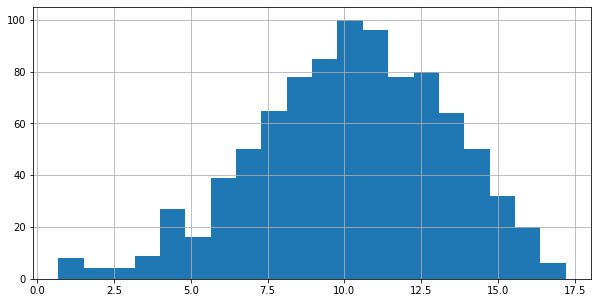

In [55]:
#some checks....
df1['TOTAL_AFFECTED'].hist(bins=20, figsize=(10,5)) #this is logarithmic and scaled(0,1)

__________________

________________________

In [56]:
df1.shape

(911, 57)

In [57]:
df1.head()

,MONTH_START,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,MAX_USA_SSHS_INLAND,V_LAND_KN,...,GDP per capita (constant 2010 US$),Net flows from UN agencies US$,"Life expectancy at birth, total (years)",Adjusted savings: education expenditure (% of GNI),Income_level_Final,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,TOTAL_AFFECTED,POP_MAX_34_ADJ_cat
0,6,117.0,4.094345,116.0,952,0.0,33.0,3.0,0.0,4.603369,...,8607.657082,0.0,67.666098,1.053572,1,16.298999,15.574055,15.015749,12.175851,"(10000000.0, 25000000.0]"
1,8,141.0,3.044522,116.0,940,0.0,31.0,3.0,1.0,4.603369,...,8607.657082,0.0,67.666098,1.053572,1,17.268928,16.562266,16.136855,13.372526,"(25000000.0, 50000000.0]"
2,8,15.0,1.098612,110.0,0,0.0,17.0,3.0,3.0,4.885828,...,3796.219401,0.0,64.770000,0.947132,1,14.339791,14.338512,13.993700,9.913438,"(1000000.0, 5000000.0]"
3,12,231.0,3.583519,120.0,924,0.0,11.0,4.0,2.0,4.780803,...,1059.467412,0.0,61.105000,1.014409,2,15.375766,14.916344,13.924162,11.002100,"(1000000.0, 5000000.0]"
4,7,84.0,2.197225,110.0,968,0.0,15.0,3.0,1.0,11.614498,...,1059.467412,0.0,61.105000,1.014409,2,15.450771,14.841368,14.502903,4.634729,"(5000000.0, 10000000.0]"


## Random forest model____________________________________

In [58]:
 #trim


In [59]:
df1.shape

(911, 57)

In [60]:
from sklearn.impute import KNNImputer

In [61]:
df1['POP_MAX_34_ADJ_cat'].isna().sum()

0

In [62]:
df1.reset_index(drop=True, inplace=True)

In [63]:
df1.tail(3)

,MONTH_START,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,MAX_USA_SSHS_INLAND,V_LAND_KN,...,GDP per capita (constant 2010 US$),Net flows from UN agencies US$,"Life expectancy at birth, total (years)",Adjusted savings: education expenditure (% of GNI),Income_level_Final,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,TOTAL_AFFECTED,POP_MAX_34_ADJ_cat
908,3,63.0,0.000000,105.0,956,4.343805,7.0,3.0,NaN,5.018603,...,478.761938,0.0,66.012095,0.732368,1,12.363582,0.000000,0.000000,7.003065,"(100000.0, 500000.0]"
909,4,27.0,3.044522,121.0,939,0.000000,11.0,4.0,3.0,4.779123,...,585.650609,0.0,58.508514,1.682688,1,15.139584,13.489782,11.959609,12.899455,"(1000000.0, 5000000.0]"
910,4,135.0,0.000000,134.0,917,0.000000,13.0,4.0,4.0,4.753590,...,1924.388377,0.0,68.951141,1.124930,2,18.165348,14.591823,10.492695,16.811243,"(50000000.0, 100000000.0]"


In [64]:
df_filled = df1.loc[:, df1.columns != 'POP_MAX_34_ADJ_cat']

In [65]:
columns = df_filled.columns

In [66]:
imputer = KNNImputer(n_neighbors=5)
df_filled = pd.DataFrame(imputer.fit_transform(df_filled))
df_filled.head()

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,6.0,117.0,4.094345,116.0,952.0,0.0,33.0,3.0,0.0,4.603369,...,67.79,8607.657082,0.0,67.666098,1.053572,1.0,16.298999,15.574055,15.015749,12.175851
1,8.0,141.0,3.044522,116.0,940.0,0.0,31.0,3.0,1.0,4.603369,...,67.79,8607.657082,0.0,67.666098,1.053572,1.0,17.268928,16.562266,16.136855,13.372526
2,8.0,15.0,1.098612,110.0,0.0,0.0,17.0,3.0,3.0,4.885828,...,69.93,3796.219401,0.0,64.770000,0.947132,1.0,14.339791,14.338512,13.993700,9.913438
3,12.0,231.0,3.583519,120.0,924.0,0.0,11.0,4.0,2.0,4.780803,...,25.68,1059.467412,0.0,61.105000,1.014409,2.0,15.375766,14.916344,13.924162,11.002100
4,7.0,84.0,2.197225,110.0,968.0,0.0,15.0,3.0,1.0,11.614498,...,25.68,1059.467412,0.0,61.105000,1.014409,2.0,15.450771,14.841368,14.502903,4.634729


In [67]:
df_filled = df_filled.rename(columns = dict(zip(df_filled.columns, columns), inplace = True))

In [68]:
df_filled.columns

Index(['MONTH_START', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'MAX_WIND',
       'MIN_PRES', 'MIN_DIST2LAND', 'MAX_STORMSPEED', 'MAX_USA_SSHS',
       'MAX_USA_SSHS_INLAND', 'V_LAND_KN', 'DISTANCE_TRACK',
       'DISTANCE_TRACK_VINCENTY', 'Landing', 'SUB BASIN_AS', 'SUB BASIN_BB',
       'SUB BASIN_CP', 'SUB BASIN_CS', 'SUB BASIN_EA', 'SUB BASIN_EP',
       'SUB BASIN_GM', 'SUB BASIN_NAm', 'SUB BASIN_SI', 'SUB BASIN_SP',
       'SUB BASIN_WA', 'SUB BASIN_WP', 'NATURE_DS', 'NATURE_ET', 'NATURE_MX',
       'NATURE_NR', 'NATURE_SS', 'NATURE_TS', 'GENERAL_CATEGORY_Cat 1',
       'GENERAL_CATEGORY_Cat 2', 'GENERAL_CATEGORY_Cat 3',
       'GENERAL_CATEGORY_Cat 4', 'GENERAL_CATEGORY_Cat 5',
       'GENERAL_CATEGORY_TD', 'GENERAL_CATEGORY_TS', 'TOTAL_DAMAGE_(000$)',
       'CALC_assets_emdat', 'TOTAL_DEATHS', 'POP_DEN_SQ_KM', 'RURAL_POP(%)',
       'HDI', 'Arable land (hectares per person)',
       'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'G

In [69]:
df_filled['POP_MAX_34_ADJ_cat'] = df1['POP_MAX_34_ADJ_cat']

In [70]:
#trimming
# df_filled=  df_filled[df_filled['TOTAL_AFFECTED'] > 6] 
# df_filled=  df_filled[df_filled['TOTAL_AFFECTED'] < 12] 

In [71]:
X = df_filled[features1] #features

y = df_filled['TOTAL_AFFECTED']

In [72]:
X.shape

(911, 51)

- Splitting the dataset using stratified sampling

In [73]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [74]:
test_split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
#train_split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)

for train_index, test_index in test_split.split(X, X[strat_col +'_cat']):
    train_set = X.iloc[train_index]
    prov_train_label = y.iloc[train_index]
    strat_test_set = X.iloc[test_index]
    strat_test_label = y.iloc[test_index]

'''
for train_index, val_index in train_split.split(train_set, train_set[strat_col +'_cat']):
    strat_train_set = train_set.iloc[train_index]
    strat_train_label = prov_train_label.iloc[train_index]
    strat_val_set = train_set.iloc[val_index]
    strat_val_label = y.iloc[test_index]
'''

"\nfor train_index, val_index in train_split.split(train_set, train_set[strat_col +'_cat']):\n    strat_train_set = train_set.iloc[train_index]\n    strat_train_label = prov_train_label.iloc[train_index]\n    strat_val_set = train_set.iloc[val_index]\n    strat_val_label = y.iloc[test_index]\n"

In [75]:
train_set.shape, prov_train_label.shape,  strat_test_set.shape, strat_test_label.shape

((728, 51), (728,), (183, 51), (183,))

In [76]:
train_set.groupby('POP_MAX_34_ADJ_cat').count()

,MONTH_START,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,MAX_USA_SSHS_INLAND,V_LAND_KN,...,Arable land (hectares per person),Cereal yield (kg per hectare),Food production index (2004-2006 = 100),GDP per capita (constant 2010 US$),"Life expectancy at birth, total (years)",Adjusted savings: education expenditure (% of GNI),Income_level_Final,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ
POP_MAX_34_ADJ_cat,,,,,,,,,,,,,,,,,,,,,
"(-0.001, 10000.0]",7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
"(10000.0, 100000.0]",29,29,29,29,29,29,29,29,29,29,...,29,29,29,29,29,29,29,29,29,29
"(100000.0, 500000.0]",29,29,29,29,29,29,29,29,29,29,...,29,29,29,29,29,29,29,29,29,29
"(500000.0, 1000000.0]",28,28,28,28,28,28,28,28,28,28,...,28,28,28,28,28,28,28,28,28,28
"(1000000.0, 5000000.0]",153,153,153,153,153,153,153,153,153,153,...,153,153,153,153,153,153,153,153,153,153
"(5000000.0, 10000000.0]",94,94,94,94,94,94,94,94,94,94,...,94,94,94,94,94,94,94,94,94,94
"(10000000.0, 25000000.0]",165,165,165,165,165,165,165,165,165,165,...,165,165,165,165,165,165,165,165,165,165
"(25000000.0, 50000000.0]",101,101,101,101,101,101,101,101,101,101,...,101,101,101,101,101,101,101,101,101,101
"(50000000.0, 100000000.0]",74,74,74,74,74,74,74,74,74,74,...,74,74,74,74,74,74,74,74,74,74


In [77]:
#Renaming for usability purposes
X_train = train_set
y_train = prov_train_label

X_test = strat_test_set
y_test = strat_test_label

In [80]:
X_train = X_train.drop('POP_MAX_34_ADJ_cat' , axis='columns')

In [82]:
X_test= X_test.drop('POP_MAX_34_ADJ_cat' , axis='columns')

In [83]:
X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

In [84]:
X_train.shape

(728, 50)

In [85]:
X = pd.DataFrame(pd.concat([X_train,X_test]))

In [86]:
y = pd.DataFrame(pd.concat([y_train,y_test]))

- Using RandomForestRegressor with Cross Validation

In [97]:
estimator_RF = RandomForestRegressor(n_estimators=1000)
estimator_RF.fit(X_train,y_train)
print(f"R-squared for train set: {estimator_RF.score(X_train, y_train):.2f}")
print("--------------------------------------------")
y_pred = estimator_RF.predict(X_test)
print("------Feature importances---------------------")
print(estimator_RF.feature_importances_)
print("--------------------------------------------")
score_estimator = estimator_RF.score(X_test, y_test)
print("R-squared for test set =", score_estimator)
mse = mean_squared_error(y_test,y_pred)
print("RF estimator mean_squared_error = ", mse)
rmse = math.sqrt(mse)
print("RF estimator root_mean_squared_error = ", rmse)
cvs = cross_val_score(estimator_RF, X, y, scoring= 'neg_root_mean_squared_error').mean()
print("cross_val =neg_root_mean_squared_error mean = ", cvs)


R-squared for train set: 0.91
--------------------------------------------
------Feature importances---------------------
[2.08761831e-02 3.62663164e-02 3.01160105e-02 2.89542396e-02
 5.15285580e-02 4.00621506e-03 3.20220346e-02 5.64203055e-03
 2.60391332e-02 4.99191530e-02 4.18113355e-02 1.09295415e-03
 1.30080163e-04 1.34377121e-03 2.44895098e-05 1.65369139e-03
 7.23227118e-05 4.50279189e-04 8.80528742e-04 1.60330959e-03
 3.29853369e-04 1.45812333e-04 9.99336251e-05 1.73717769e-03
 1.08252175e-05 1.86523353e-03 1.09970401e-04 8.40390227e-04
 7.88786487e-05 1.06339599e-03 2.83340182e-03 5.74800138e-03
 1.48636001e-03 1.87659604e-03 4.24597580e-04 1.11745806e-03
 3.76283796e-03 6.20397327e-02 1.05684037e-01 3.89017987e-02
 3.49871110e-02 3.30897820e-02 3.68387201e-02 6.63800796e-02
 2.26895439e-02 3.37313459e-02 1.90586737e-03 6.41673853e-02
 7.70286427e-02 6.45925941e-02]
--------------------------------------------
R-squared for test set = 0.3057082134229856
RF estimator mean_squared

C:\Users\torre\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\torre\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\torre\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\torre\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

cross_val =neg_root_mean_squared_error mean =  -2.5257138037160116


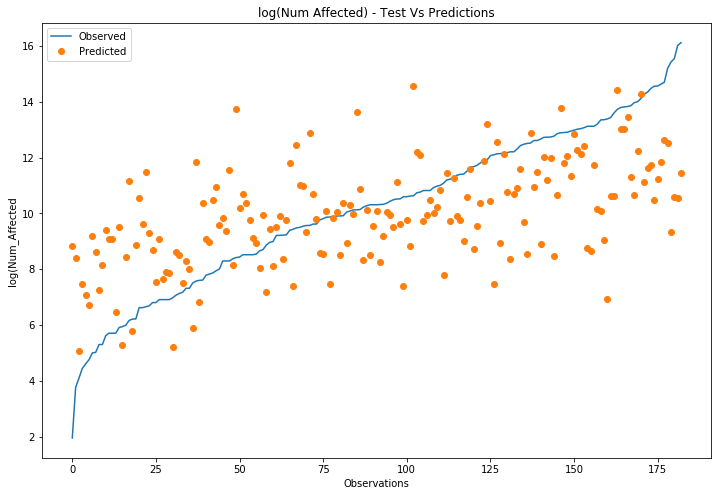

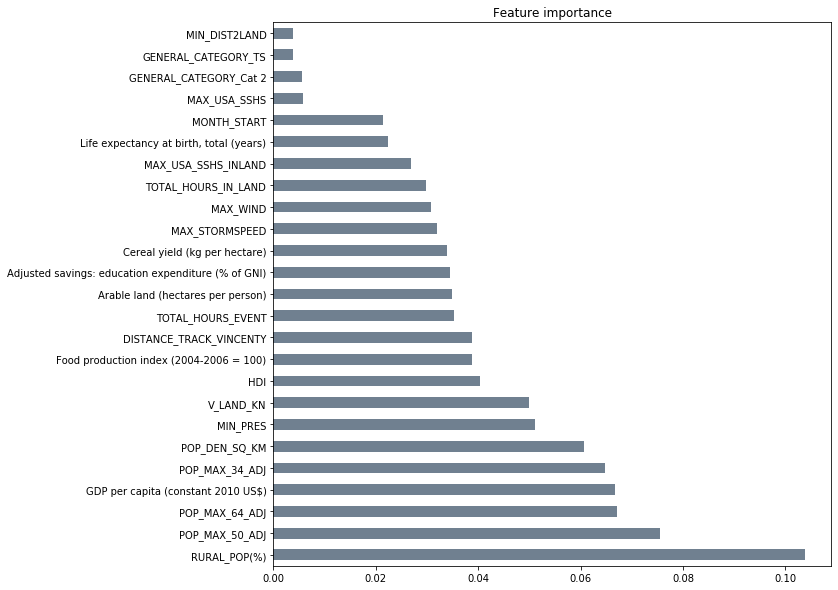

In [89]:
##################### Plotting results #########################
df_y = pd.DataFrame(y_test) 
    
    # Visualising the Random Forest Regression results  
df_y['Pred_Total_Affected'] = y_pred 
df_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot
df_y.reset_index(inplace=True, drop=True) #Resetting index
    
    # plt for the Random Forest Regression results ++
plt.figure(figsize=(12,8))
plt.plot(df_y.index, df_y['TOTAL_AFFECTED'], label = 'Observed')
plt.plot(df_y.index, df_y['Pred_Total_Affected'], 'o', label = 'Predicted')
plt.xlabel('Observations')
plt.ylabel('log(Num_Affected')
plt.title('log(Num Affected) - Test Vs Predictions')
    # show a legend on the plot
plt.legend()
    # Display a figure.
plt.show()
    
    
    #Feat_importances plotting
feat_importances = pd.Series(estimator_RF.feature_importances_, index = X.columns)
feat_importances.nlargest(25).plot(kind = "barh", 
                                       figsize= (10,10), 
                                       color = "slategrey",
                                       title = "Feature importance" )

### Hyperparameter tunning with grid search

In [102]:
parameters = {'n_estimators':[100, 500, 1000], 
              'max_depth':[5, 10, 20, 40],
              'max_features':[10, 15, 20, 30]              
             }

In [103]:
estimator_RF = GridSearchCV(RandomForestRegressor(), parameters, cv = 3, scoring= 'neg_root_mean_squared_error',
                            return_train_score = False)

In [104]:
estimator_RF.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [105]:
GS_results = pd.DataFrame(estimator_RF.cv_results_)
GS_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_max_features', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [106]:
cols_needed = ['param_max_depth', 'param_max_features', 'param_n_estimators', 'mean_test_score','rank_test_score']
GS_results = GS_results[cols_needed]
GS_results.sort_values(by=['rank_test_score'], ascending = True)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,rank_test_score
27,20,15,100,-2.617060,1
39,40,15,100,-2.623535,2
25,20,10,500,-2.626007,3
14,10,10,1000,-2.627228,4
37,40,10,500,-2.627502,5
38,40,10,1000,-2.628899,6
28,20,15,500,-2.629545,7
44,40,20,1000,-2.629707,8
32,20,20,1000,-2.630070,9
23,10,30,1000,-2.630198,10


In [107]:
print(np.abs(estimator_RF.best_score_))
print(estimator_RF.best_params_)

2.617060354404218
{'max_depth': 20, 'max_features': 15, 'n_estimators': 100}


- Plotting with another chart

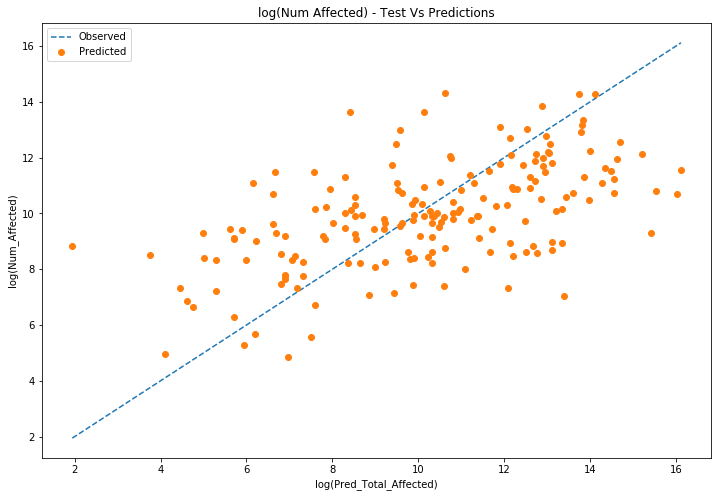

In [108]:
df_y = pd.DataFrame(y_test) 
    
    # Visualising the Random Forest Regression results  
df_y['Pred_Total_Affected'] = y_pred 
df_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot
df_y.reset_index(inplace=True, drop=True) #Resetting index
    
    # plt for the Random Forest Regression results ++
plt.figure(figsize=(12,8))
plt.plot(df_y['TOTAL_AFFECTED'], df_y['TOTAL_AFFECTED'], '--', label = 'Observed')
plt.plot(df_y['TOTAL_AFFECTED'], df_y['Pred_Total_Affected'], 'o', label = 'Predicted')

plt.xlabel('log(Pred_Total_Affected)')
plt.ylabel('log(Num_Affected)')
#plt.xlim(0,100)
plt.title('log(Num Affected) - Test Vs Predictions')

    # show a legend on the plot
plt.legend()
    # Display a figure.
plt.show()

- Plotting Absolute Error of each observed data point in test data

In [109]:
df_y['error'] = abs(df_y['Pred_Total_Affected'] - df_y['TOTAL_AFFECTED'])

In [110]:
df_y['error'].describe()

count    183.000000
mean       1.879727
std        1.446489
min        0.024617
25%        0.739644
50%        1.458887
75%        2.912578
max        6.894563
Name: error, dtype: float64

No handles with labels found to put in legend.


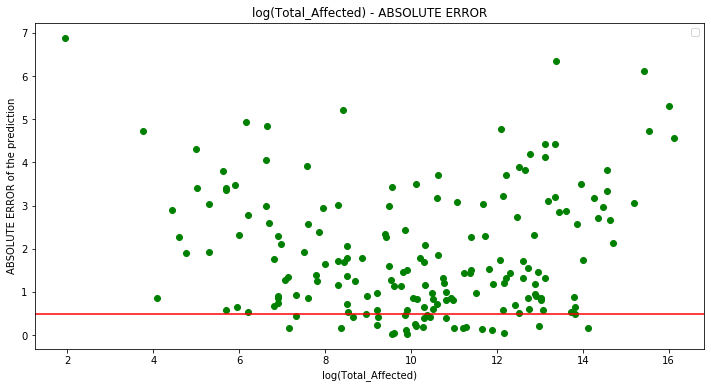

In [111]:
plt.figure(figsize=(12,6))
plt.plot(df_y['TOTAL_AFFECTED'], df_y['error'] , 'og')
plt.axhline(y=0.5,c='r')
plt.xlabel('log(Total_Affected)')
plt.ylabel('ABSOLUTE ERROR of the prediction')
#plt.xlim(0,100)
plt.title('log(Total_Affected) - ABSOLUTE ERROR')

    # show a legend on the plot
plt.legend()
    # Display a figure.
plt.show()

### Using Sequential Feature Selection

http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [ ]:
# df_filled =  df_filled[df_filled['TOTAL_AFFECTED'] > 0.4] 
# df_filled =  df_filled[df_filled['TOTAL_AFFECTED'] < 0.9]

In [ ]:
df_filled.shape

In [ ]:
X = df_filled[features1] #features
# X = df_scaled[features3].fillna(df.mean())
y = df_filled['TOTAL_AFFECTED']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #(X_pca, y, test_size=0.3)

In [ ]:
estimator_RF = RandomForestRegressor(n_estimators=1000)

In [ ]:
sfs1 = SFS(estimator_RF, 
           k_features=10, 
           forward=True, 
           floating=True, 
           verbose=2,
           scoring='neg_root_mean_squared_error',
           cv=0)

In [ ]:
sfs1 = sfs1.fit(X_train, y_train)

In [ ]:
sfs1.subsets_

In [ ]:
#TOP_10 Selected features
top_10_features = list(sfs1.k_feature_names_)
top_10_features

In [ ]:
# df_filled_trim =  df_filled[(df_filled['TOTAL_AFFECTED']>2) & (df_filled['TOTAL_AFFECTED']<5)]

In [ ]:
X = df_filled[top_10_features] #features
# X = df_scaled[features3].fillna(df.mean())
y = df_filled['TOTAL_AFFECTED']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #(X_pca, y, test_size=0.3)

In [ ]:
estimator_RF = RandomForestRegressor(n_estimators=1000)
estimator_RF.fit(X_train,y_train)

print(f"R-squared for train set: {estimator_RF.score(X, y):.2f}")
print("--------------------------------------------")

y_pred = estimator_RF.predict(X_test)

print("------Feature importances---------------------")
print(estimator_RF.feature_importances_)

print("--------------------------------------------")
score_estimator = estimator_RF.score(X_test, y_test)
print("R-squared for test set =", score_estimator)

mse = mean_squared_error(y_test,y_pred)
print("RF estimator mean_squared_error = ", mse)

rmse = math.sqrt(mse)
print("RF estimator root_mean_squared_error = ", rmse)

cvs = cross_val_score(estimator_RF, X, y, scoring= 'neg_root_mean_squared_error').mean()
print("cross_val_score =neg_root_mean_squared_error mean = ", cvs)

In [ ]:
df_y = pd.DataFrame(y_test) 
    
    # Visualising the Random Forest Regression results  
df_y['Pred_Total_Affected'] = y_pred 
df_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot
df_y.reset_index(inplace=True, drop=True) #Resetting index
    
    # plt for the Random Forest Regression results ++
plt.figure(figsize=(12,8))
plt.plot(df_y.index, df_y['TOTAL_AFFECTED'], label = 'Observed')
plt.plot(df_y.index, df_y['Pred_Total_Affected'], 'o', label = 'Predicted')
plt.xlabel('Observations')
plt.ylabel('log(Num_Affected)')
#plt.xlim(0,100)
plt.title('Num Affected - Test Vs Predictions')

    # show a legend on the plot
plt.legend()
    # Display a figure.
plt.show()

In [ ]:
feat_importances = pd.Series(estimator_RF.feature_importances_, index = top_10_features)
feat_importances.nlargest(10).plot(kind = "barh", 
                                       figsize= (10,10), 
                                       color = "grey",
                                       title = "Feature importance" )

### Correlations heatmap

In [ ]:
df2 = pd.read_csv(r'Data_input/OUTPUT_WBI_exposer_cyclones_v12.csv', sep=";")

In [ ]:
df2.info()

In [ ]:
#Selecting the numerical features

numerical_features = list(df2.select_dtypes(include=['float64','int64']).columns)

In [ ]:
#New data sets to construct the correlation matrix
df2 = df2[numerical_features]

In [ ]:
#correlation matrices
corr_num = df2.corr(method = "spearman")

In [ ]:
fig, ax = plt.subplots(figsize=(18,18))
ax = plt.subplot(111)
sns.heatmap(corr_num, annot=True, linewidth=1, cmap="BrBG", ax=ax)
bottom, top = ax.get_ylim()             # this fixes a bug where first and last columns were not visualized correctly
ax.set_ylim(bottom + 0.5, top - 0.5)

___________________________
________________________________